In [120]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Данные

In [121]:
# пути к датасету
train_data_dir = 'datasets/brain_tumor_1/Training'
test_data_dir = 'datasets/brain_tumor_1/Testing'

In [122]:
# размер изображения
img_height = 32
img_width = 32
# размер батча
batch_size = 32

In [123]:
# обучающий датасет
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [124]:
# валидационный датасет
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [125]:
# тестовый датасет
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  shuffle=False,
  image_size=(img_height, img_width))

Found 1311 files belonging to 4 classes.


In [126]:
# метки классов
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [127]:
# функция нормализации входных данных 
normalization_layer = tf.keras.layers.Rescaling(1./255)
# перевод обучающего сета в оттенки серого
train_gray_ds = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
normalized_train_ds = train_gray_ds.map(lambda x, y: (normalization_layer(x), y))
# перевод валидационного сета в оттенки серого
val_gray_ds = val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
normalized_val_ds = val_gray_ds.map(lambda x, y: (normalization_layer(x), y))
# перевод тестового сета в оттенки серого
test_gray_ds = test_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
normalized_test_ds = test_gray_ds.map(lambda x, y: (normalization_layer(x), y))

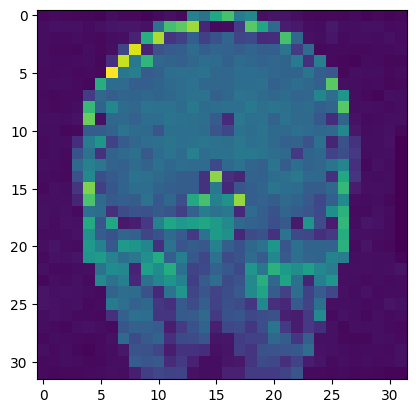

In [128]:
image_batch, labels_batch = next(iter(train_gray_ds))
first_image = image_batch[0]
plt.imshow(first_image)

# Колбеки

In [129]:
# сохранение лучшей модели
checkpoint_filepath = 'ckpt/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [130]:
# прервать обучение если точность не улучшается
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min')

In [131]:
# остановка обучения при достижении нужной точности
class TerminateOnBaseline(tf.keras.callbacks.Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

accuracy_achieved_callback = TerminateOnBaseline(monitor='val_accuracy', baseline=0.90)

# Модель

In [132]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 1)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

/Users/sergey/Projects/ml_unn/venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │        20,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,584 (80.41 KB)

 Trainable params: 20,584 (80.41 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Обучение модели

In [135]:
history = model.fit(normalized_train_ds, epochs=1000, callbacks=[accuracy_achieved_callback, early_stopping_callback, model_checkpoint_callback],
                     validation_data=normalized_val_ds)

Epoch 1/1000


/Users/sergey/Projects/ml_unn/venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4934 - loss: 1.1558 - val_accuracy: 0.6751 - val_loss: 0.8655
Epoch 2/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6776 - loss: 0.8309 - val_accuracy: 0.7102 - val_loss: 0.7505
Epoch 3/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7402 - loss: 0.7062 - val_accuracy: 0.7478 - val_loss: 0.6816
Epoch 4/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7812 - loss: 0.6333 - val_accuracy: 0.7574 - val_loss: 0.6529
Epoch 5/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8005 - loss: 0.5840 - val_accuracy: 0.7303 - val_loss: 0.6671
Epoch 6/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8097 - loss: 0.5498 - val_accuracy: 0.7487 - val_loss: 0.6376
Epoch 7/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8371 - loss: 0.5014 - val_accuracy: 0.7890 - val_loss: 0.5849
Epoch 8/1000
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8496 - loss: 0.4679 - val_accuracy:

In [136]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Text(0.5, 0, 'epoch')

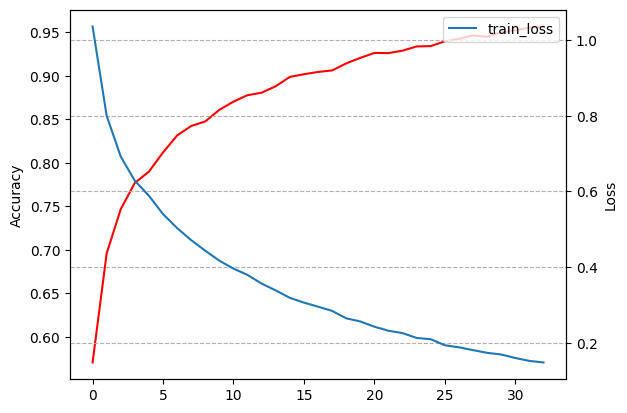

In [137]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['accuracy'], label='train_acc', color='red')
ax1.set_ylabel('Accuracy')
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='train_loss')
ax2.set_ylabel('Loss')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('epoch')

# Оценка модели

In [138]:
# загрузить лучший вариант
model.load_weights(checkpoint_filepath)

In [139]:
# оценка на тестовых данных
test_loss, test_acc = model.evaluate(normalized_test_ds, verbose=2)
print('\nTest accuracy:', test_acc)

41/41 - 0s - 7ms/step - accuracy: 0.8459 - loss: 0.4583

Test accuracy: 0.845919132232666


In [140]:
# выходы модели
predictions = model.predict(normalized_test_ds)
# классы
predicted_classes = np.argmax(predictions, axis=1)
print(len(predicted_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1311


In [141]:
# вытащим метки из тестового датасета
test_labels = np.concatenate([y for x, y in normalized_test_ds], axis=0)
print(len(test_labels))

1311


In [142]:
print(classification_report(test_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       300
           1       0.70      0.75      0.72       306
           2       0.93      0.97      0.95       405
           3       0.92      0.90      0.91       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



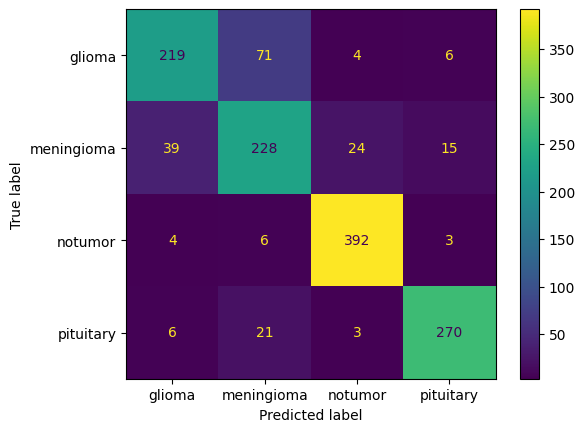

In [143]:
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

# Сохранение

In [144]:
model.save('brain_tumor_1_model.keras')